# Confusion Scheme Learning

### Methodology and Results: Quantum Monte Carlo simulation of an electron-phonon model

**Learning By Confusion** (LBC) is a machine learning technique for detecting phase transitions, first introduced by van Nieuwenberg <i>et. al.</i> in <i>"Learning phase transitions by confusion",</i> [Nature Physics 13, 435-439 (2017)](https://www.nature.com/articles/nphys4037). In recent years this method has been used to detect phase transitions in a variety of classical models in condensed matter physics such as the XY-model and the q-state Potts model, however its application to <i>Quantum</i> Monte Carlo datasets has not yet been fully explored. 

In this notebook, we provide an overview of the Hamiltonian we simulate using the Hybrid Quantum Monte Carlo (HMC) algorithm, a model of the electron-phonon interaction on a lattice known as the Holstein model. At low temperature, this model exhibits a phase transition to a long-range ordered charge density wave (CDW) phase. We are interested in discovering this phase transition and estimating the critical temperature, using the LBC method. The benefit of such as approach, as we will see, is that we do not require in advance any knowledge of an order parameter. The confusion scheme approach may therefore be useful for discovering more subtle quantum phase transitions, which may be more difficult to detect by other means. 

After a brief discussion of the Hybrid Monte Carlo algorithm, we desribe our implemetation of the LBC method. In another notebook in this repository, [**Confusion-Scheme-CNN-PyTorch.ipynb**](https://github.com/owenpb/Confusion-Scheme-Learning/blob/main/Confusion-Scheme-CNN-PyTorch.ipynb), we provide a full PyTorch implementation of the LBC method for one particular set of training data (phonon field snapshots). 

Finally, we explore the efficacy of various types of Quantum Monte Carlo datasets for discovering the Holstein phase transition via the LBC approach, and provide a summary of our results. 

## 1. The Holstein model

Here we will briefly describe the Hamiltonian under study: the Holstein model. This is a description of the electron-phonon interaction on a lattice, which can be split up into three parts. The first is an electron kinetic energy term $\hat{K}$, which describes nearest-neighbor electron hopping on a lattice. A key feature of the Holstein model is that on each site $i$, there are quantum harmonic oscillators (phonons) of frequency $\omega_0$, with $X_i$ and $P_i$ the corresponding position and momentum operators. Thus the Hamiltonian contains a second term $\hat{U}$ giving the phonon kinetic and potential energies. The last term, $\hat{V}$, is the **electron-phonon interaction** which takes the form of the electron density $n$ at a site $i$ coupled to the phonon displacement $x$ at that site.

$ \hat{H} = \hat{K} + \hat{U} + \hat{V}$

where:

$\hat{K} = -t \sum_{\langle i, j \rangle, \sigma} (\hat{c}^\dagger_{i,\sigma} \hat{c}_{j,\sigma} + \hat{c}^\dagger_{j,\sigma} \hat{c}_{i,\sigma}) - \mu \sum_{i,\sigma} \hat{n}_{i,\sigma}$

$\hat{U} = \frac{1}{2}\sum_i \hat{P}_i^2 + \frac{\omega_0}{2}\sum_i \hat{X}_i^2$

$\hat{V} = \lambda \sum_{i, \sigma} \hat{n}_{i, \sigma} \hat{X}_i$

with $\hat{c}^\dagger_{i,\sigma}$ denoting an electron creation operator at site $i$ with spin $\sigma=\{\uparrow \downarrow \}$. The model has an on-site electron-phonon coupling, which crucially leads to an effective electron-electron attraction, and therefore pairing of electrons. At low temperature, these can condense into a long-range ordered phase.

On a square lattice at half-filling, previous numerical studies have found a phase transition to charge density wave (CDW) order, which has the form of a checkerboard pattern of alternating doubly occupied and empty sites. These previous studies [[Phys. Rev. Lett. 120, 187003 (2018)]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.120.187003) estimate a critical inverse temperature of $\beta_c=6.0 \pm 0.1$, obtained by studying many different lattice sizes and performing a finite-size scaling of a known order parameter (a specified quantity which is measured during the simulation). 

## 2. Hybrid Quantum Monte Carlo

We use the Julia package [ElPhDynamics](https://github.com/cohensbw/ElPhDynamics) to perform Hybrid Monte Carlo (HMC) simulations of the Holstein model on $12 \times 12$ square lattices. Although we will not go into details of the algorithm here, note this is a Monte Carlo technique which allows us to sample states of the Holstein model at a fixed finite temperature. A key concept in HMC (and other Quantum Monte Carlo techniques) is that the inverse temperature $\beta$ is discretized along an "imaginary time" axis. We can write $\beta = L \Delta\tau$ where $L$ is the number of imaginary time "slices" and $\Delta\tau$ is the discretization.

A key consequence is that, for the case of the Holstein model, the phonon displacement variables $x_i$ acquire an additional index $\tau$, for imaginary time. We subsequently perform a Monte Carlo sampling of the phonon field $x_{i, \tau}$, i.e., the set of phonon displacement variables, performing a large number $n_\textrm{meas}$ of measurement sweeps, and through appropriate combinations of fermion greens functions, we can make measurements of physical quantities such as electron density, kinetic energy, density correlations, etc.

In this notebook, we will explore the efficacy of several kinds of HMC measurements in discovering the Holstein phase transition via the LBC approach:

1. **Snapshots of the phonon field configurations** (taken every $n_s$ measurement sweeps)
2. **Snapshots of the electron density configurations** (taken every $n_s$ measurement sweeps)
3. **Position-space Density-density correlation data** (for $n_\tau$ imaginary times)
4. **Momentum-space Density-density correlation data** (for $n_\tau$ imaginary times)

For additional details of our Hybrid Monte Carlo algorithm, see our publication:

[B. Cohen-Stead, O. Bradley, C. Miles, G. Batrouni, R. Scalettar, and K. Barros. <i>Fast and scalable quantum Monte Carlo simulations of electron-phonon models. </i> Phys. Rev. E 105, 065302 (2022)](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.105.065302)

## 3. Learning By Confusion

Here we will outline the LBC method applied to our Quantum Monte Carlo datasets. For each of the datasets specified above, we partition a training set which we provide to a Convolutional Neural Network (CNN), which is well-suited for detecting spatial features (e.g. CDW order) in data. However, the data is not labeled as belonging to either the disordered phase or the order phase. Note the data is completely unlabeled and our aim is discover the underlying pattern characterizing the onset of long-range order, hence this is an unsupervised learning task. However, the LBC method <i>assigns</i> "fake" labels to our data, based on a guess for the critical inverse temperature $\beta_c$, which our network learns to predict; i.e. supervised binary classification. 

We want to determine the critical inverse temperature $\beta_c$. For a range of values in $[\beta_\textrm{min}, \beta_\textrm{max}]$, we propose a <i>guess</i> for $\beta_c$ and assign target labels $y$ to our initially unlabeled data as follows:

$y=0: \,\, \beta \geq \beta_c$

$y=1: \,\, \beta < \beta_c$


After splitting our image data into train/test sets, we train a CNN to predict these assignments. The guessed value of $\beta_c$ is varied across the range $[\beta_\textrm{min}, \beta_\textrm{max}]$ and we record a classification accuracy for each value.

At the extremes of our temperature range, we our classication accuracy will approach $1$. For example, when our guess $\beta_c = \beta_\textrm{min}$, all samples recieve the label $y=1$ (and none will be labeled $y=0$) which our classifier will learn with $100\%$ accuracy. Clearly, we expect classification accuracy to decrease as our guess moves away from $\beta_\textrm{min}$ or $\beta_\textrm{min}$. 

If the guess for $\beta_c$ lies below the <i>true</i> critical value, many ordered and disordered configurations will share the same label. Therefore, the classifier gets "confused" and the classification accuracy is reduced. However, if the guess for $\beta_c$ coincides with the true critical temperature, the $y=0$ and $y=1$ labels should properly separate the ordered and disordered phases, which the network then can learn to distinguish with high accuracy. 

As a result, we expect a **W-shape** in a plot of classification accuracy vs. $\beta_c$, where the position of the **central peak** should locate the phase transition. For further details, see <i>"Learning phase transitions by confusion",</i> [Nature Physics 13, 435-439 (2017)](https://www.nature.com/articles/nphys4037) which illustrates this behavior for the classical Ising model.

## 4. Training CNN in PyTorch

In another notebook in this repository, [**Confusion-Scheme-CNN-PyTorch.ipynb**](https://github.com/owenpb/Confusion-Scheme-Learning/blob/main/Confusion-Scheme-CNN-PyTorch.ipynb) we provide a full implementation of the LBC method for one particular set of training data (phonon field snapshots with $n_s=50$). There we provides details of the architecture of our CNN, which we construct with PyTorch using nn.Sequential. Our training phase implements early stopping, dropout, and Adam optimization with L2 regularization.  

## 5. Results: Accuracy vs. $\beta_c$

In each of the plots below, we observe the characteristic W-peak in accuracy vs. $\beta_c$, which provides us with an estimate for the critical temperature which we indicate using a dashed line.

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Load temperature array
Tcs_values = np.load('data/accuracy_results/density_snapshots/density_snapshot_Tcs_ns20.npy')

# Load accuracy results obtained via density snapshot data
density_snapshot_accuracies_ns20 = np.load('data/accuracy_results/density_snapshots/density_snapshot_accuracies_ns20.npy')
density_snapshot_accuracies_ns25 = np.load('data/accuracy_results/density_snapshots/density_snapshot_accuracies_ns25.npy')
density_snapshot_accuracies_ns50 = np.load('data/accuracy_results/density_snapshots/density_snapshot_accuracies_ns50.npy')
density_snapshot_accuracies_ns100= np.load('data/accuracy_results/density_snapshots/density_snapshot_accuracies_ns100.npy')

# Load accuracy results obtained via phonon snapshot data
phonon_snapshot_accuracies_ns20 = np.load('data/accuracy_results/phonon_snapshots/phonon_snapshot_accuracies_ns20.npy')
phonon_snapshot_accuracies_ns25 = np.load('data/accuracy_results/phonon_snapshots/phonon_snapshot_accuracies_ns25.npy')
phonon_snapshot_accuracies_ns50 = np.load('data/accuracy_results/phonon_snapshots/phonon_snapshot_accuracies_ns50.npy')
phonon_snapshot_accuracies_ns100 = np.load('data/accuracy_results/phonon_snapshots/phonon_snapshot_accuracies_ns100.npy')

# Load accuracy results obtained via imaginary-time resolved density-density correlation data (position space)
denden_corr_position_accuracies_nit3 = np.load('data/accuracy_results/density_correlations_position/denden_corr_position_accuracies_nit3.npy')
denden_corr_position_accuracies_nit4 = np.load('data/accuracy_results/density_correlations_position/denden_corr_position_accuracies_nit4.npy')
denden_corr_position_accuracies_nit5 = np.load('data/accuracy_results/density_correlations_position/denden_corr_position_accuracies_nit5.npy')
denden_corr_position_accuracies_nit10 = np.load('data/accuracy_results/density_correlations_position/denden_corr_position_accuracies_nit10.npy')

# Load accuracy results obtained via imaginary-time resolved density-density correlation data (momentum space)
denden_corr_momentum_accuracies_nit3 = np.load('data/accuracy_results/density_correlations_momentum/denden_corr_momentum_accuracies_nit3.npy')
denden_corr_momentum_accuracies_nit4 = np.load('data/accuracy_results/density_correlations_momentum/denden_corr_momentum_accuracies_nit4.npy')
denden_corr_momentum_accuracies_nit5 = np.load('data/accuracy_results/density_correlations_momentum/denden_corr_momentum_accuracies_nit5.npy')
denden_corr_momentum_accuracies_nit10 = np.load('data/accuracy_results/density_correlations_momentum/denden_corr_momentum_accuracies_nit10.npy')

### 5.1. Electron density snapshot data:

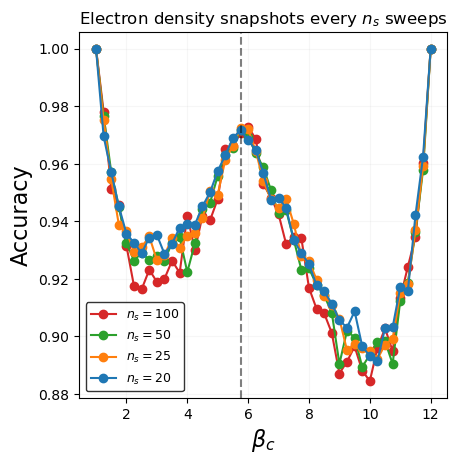

In [26]:
plt.figure(figsize=(4.75, 4.75))
plt.plot(Tcs_values, density_snapshot_accuracies_ns100, '-o', color='tab:red', label=r'$n_s=100$')
plt.plot(Tcs_values, density_snapshot_accuracies_ns50, '-o', color='tab:green', label=r'$n_s=50$')
plt.plot(Tcs_values, density_snapshot_accuracies_ns25, '-o', color='tab:orange', label=r'$n_s=25$')
plt.plot(Tcs_values, density_snapshot_accuracies_ns20, '-o', color='tab:blue', label=r'$n_s=20$')
plt.grid(alpha=0.1)
plt.axvline(x=5.75, color='k', linestyle='dashed', alpha=0.5)
plt.legend(frameon=True, edgecolor='k', fontsize=9)
plt.xlabel(r'$\beta_c$', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Electron density snapshots every ' + r'$n_s$' ' sweeps')
plt.show()

### 5.2. Phonon field snapshot data:

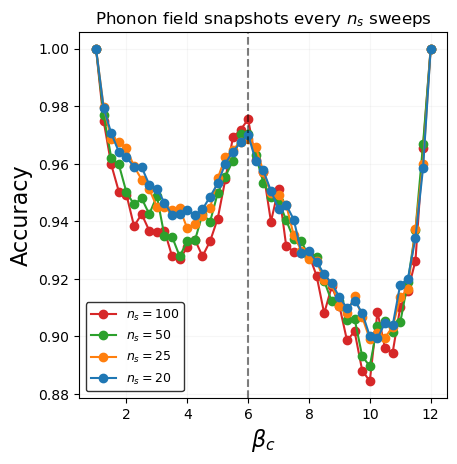

In [25]:
plt.figure(figsize=(4.75, 4.75))
plt.plot(Tcs_values, phonon_snapshot_accuracies_ns100, '-o', color='tab:red', label=r'$n_s=100$')
plt.plot(Tcs_values, phonon_snapshot_accuracies_ns50, '-o', color='tab:green', label=r'$n_s=50$')
plt.plot(Tcs_values, phonon_snapshot_accuracies_ns25, '-o', color='tab:orange', label=r'$n_s=25$')
plt.plot(Tcs_values, phonon_snapshot_accuracies_ns20, '-o', color='tab:blue', label=r'$n_s=20$')
plt.grid(alpha=0.1)
plt.axvline(x=6.0, color='k', linestyle='dashed', alpha=0.5)
plt.legend(frameon=True, edgecolor='k', fontsize=9)
plt.xlabel(r'$\beta_c$', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Phonon field snapshots every ' + r'$n_s$' ' sweeps')
plt.show()

### 5.3. Density-density correlation data (position space):

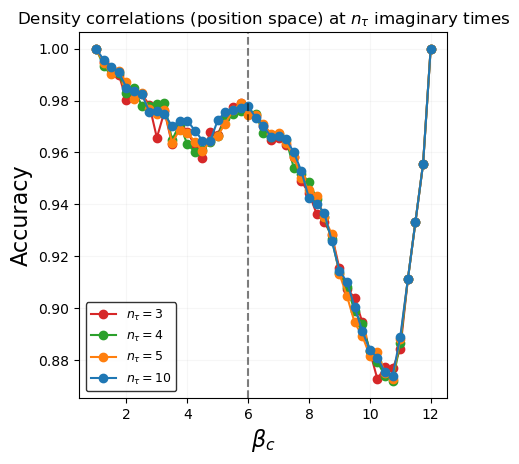

In [28]:
plt.figure(figsize=(4.75, 4.75))
plt.plot(Tcs_values, denden_corr_position_accuracies_nit3, '-o', color='tab:red', label=r'$n_\tau=3$')
plt.plot(Tcs_values, denden_corr_position_accuracies_nit4, '-o', color='tab:green', label=r'$n_\tau=4$')
plt.plot(Tcs_values, denden_corr_position_accuracies_nit5, '-o', color='tab:orange', label=r'$n_\tau=5$')
plt.plot(Tcs_values, denden_corr_position_accuracies_nit10, '-o', color='tab:blue', label=r'$n_\tau=10$')
plt.grid(alpha=0.1)
plt.axvline(x=6.0, color='k', linestyle='dashed', alpha=0.5)
plt.legend(frameon=True, edgecolor='k', fontsize=9)
plt.xlabel(r'$\beta_c$', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Density correlations (position space) at ' + r'$n_\tau$' ' imaginary times')
plt.show()

### 5.4. Density-density correlation data (momentum space):

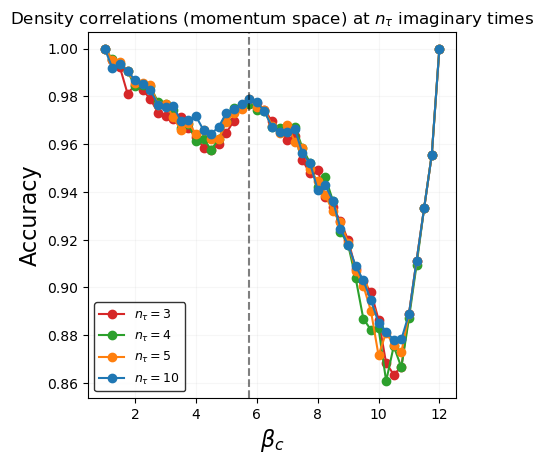

In [29]:
plt.figure(figsize=(4.75, 4.75))
plt.plot(Tcs_values, denden_corr_momentum_accuracies_nit3, '-o', color='tab:red', label=r'$n_\tau=3$')
plt.plot(Tcs_values, denden_corr_momentum_accuracies_nit4, '-o', color='tab:green', label=r'$n_\tau=4$')
plt.plot(Tcs_values, denden_corr_momentum_accuracies_nit5, '-o', color='tab:orange', label=r'$n_\tau=5$')
plt.plot(Tcs_values, denden_corr_momentum_accuracies_nit10, '-o', color='tab:blue', label=r'$n_\tau=10$')
plt.grid(alpha=0.1)
plt.axvline(x=5.75, color='k', linestyle='dashed', alpha=0.5)
plt.legend(frameon=True, edgecolor='k', fontsize=9)
plt.xlabel(r'$\beta_c$', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Density correlations (momentum space) at ' + r'$n_\tau$' ' imaginary times')
plt.show()

## 6. Summary

In each case shown above, our LBC estimate of the transition point is around $\beta_c \approx 6$, which agrees with previously known results for this model. More traditional techniques for determining $\beta_c$ (e.g. performing simulations for a range of lattice sizes followed by finite-size scaling of a chosen order parameter) yield a value of $\beta_c = 6.0 \pm 0.1$ for the Holstein model parameters we study here, i.e. $\omega_0/t=1$ and $\lambda_D=0.25$. Please refer to the reference <i>Phonon Dispersion and the Competition between Pairing and Charge Order</i>, Costa <i>et. al.</i> [Phys. Rev. Lett 120, 187003 (2018)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.120.187003) for further details.

Here we can conclude there are some clear advantageous practices to keep in mind using the LBC approach with Quantum Monte Carlo data:

1. Combining data across several imaginary times is beneficial for resolving the W-shape. For our imaginary-time resolved correlation data, this worked much better than using equal-time ($n_\tau=1$) data only.
2. Saving snapshots of local quantities continuously throughout a QMC simulation is highly recommended. For the Holstein model, snapshots of electron densities $\{n\}$ and the phonon displacement field $\{ x \}$ produced a sharp peak in accuracy at the known value of $\beta_c$.
3. Taking the Fourier transform of correlation data as input to the CNN achieves similar performance to real-space data for detecting the CDW transition on a square lattice. However, in general, using the Fourier transform of correlation data as input to the CNN may be advantageous for detecting other varieties of phase transition.

It should be emphasized that unlike alternative approaches for finding $\beta_c$, advance knowledge of the order parameter is not needed. Indeed, we discovered the Holstein model phase transition and estimated its critical temperature using raw Quantum Monte Carlo datasets without reference a CDW structure factor. 

The **learning by confusion** approach therefore may be a potential tool one can use for locating more subtle quantum phase transitions -- particularly those which may be more difficult to detect or for which an order parameter is unknown.